In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import sys
from scipy.optimize import minimize
mpl.rcParams.update({'font.size': 20})
mpl.rcParams.update({'axes.linewidth': 2})

## Models for fitting

In [2]:
# Define the model: falling power law
def power_law_basic(x, A, alpha):
    return A * x**(-alpha)

def power_law(x, A, alpha, x0, k):
    return A * x**(-alpha) / (1 + np.exp(-(x - x0)*k))

# Define the model: falling exponential
def exponential_basic(x, A, alpha):
    return A * np.exp(-x * alpha)

def exponential(x, A, alpha, x0, k):
    return A * np.exp(-x * alpha) / (1 + np.exp(-(x - x0)*k))

# Negative log likelihood function to minimize
def negative_log_likelihood_power(params, x, counts):
    A, alpha, x0, k = params
    y = power_law(x, A, alpha, x0, k)
    nll = np.sum(y - counts * np.log(y))
    return nll

# Negative log likelihood function to minimize
def negative_log_likelihood_exp(params, x, counts):
    A, alpha, x0, k = params
    y = exponential(x, A, alpha, x0, k)
    nll = np.sum(y - counts * np.log(y))
    return nll

# Negative log likelihood function to minimize
def negative_log_likelihood_power_basic(params, x, counts):
    A, alpha = params
    y = power_law_basic(x, A, alpha)
    nll = np.sum(y - counts * np.log(y))
    return nll

# Negative log likelihood function to minimize
def negative_log_likelihood_exp_basic(params, x, counts):
    A, alpha = params
    y = exponential_basic(x, A, alpha)
    nll = np.sum(y - counts * np.log(y))
    return nll


## Getting fit parameters for exponential and power laws

In [3]:
energies_eV = np.load('spectra/BigFins_shared_0719.npy')

mass_kg = (1 * 1 * 0.1) * 2.329 * 1e-3
time_days = 3 / 24.
time_sec = time_days * 86400

print(f'{len(energies_eV)} events')
print(f'{mass_kg * 1000:.4f} grams of Si')


6967 events
0.2329 grams of Si


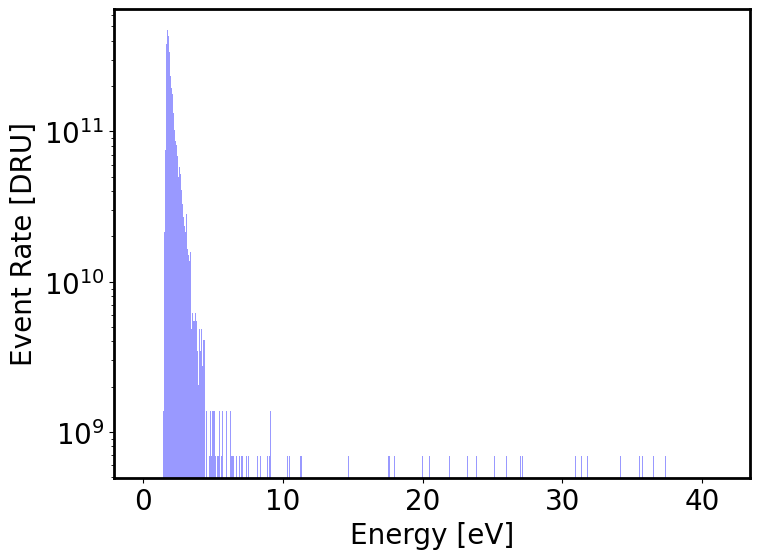

In [4]:
bins_eV_full = np.arange(0, max(energies_eV) + 4, 0.05)

event_weights_DRU = np.full(len(energies_eV), (1/mass_kg/time_days/np.diff(bins_eV_full*1e-3)[0]))

####### Plotting #######

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.hist(energies_eV, bins_eV_full, weights=event_weights_DRU, alpha=0.4, color='b')
ax.set_yscale('log')

ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Event Rate [DRU]')


fig.tight_layout()


Power law parameters: A = 1.241e+13 DRU, exponent = -5.7717
Threshold = 1.657 eV, width = 0.03177 eV
Exponential parameters: A = 2.972e+13 DRU, E0 = 0.4137 eV
Threshold = 1.641 eV, width = 0.02969 eV


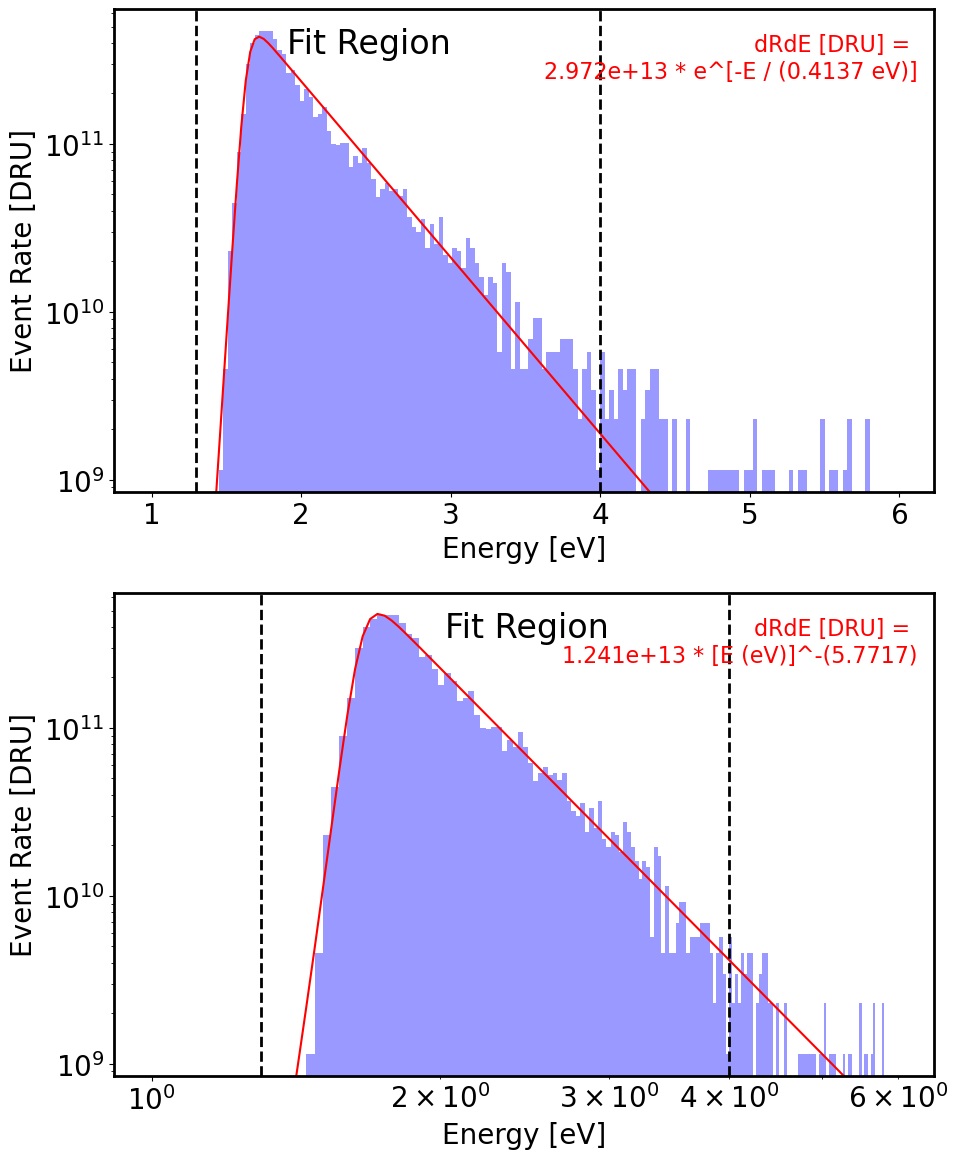

In [5]:
bins_eV_full = np.arange(1, 6, 0.03)
fit_low, fit_high = 1.3, 4
bins_eV_fit = bins_eV_full[(bins_eV_full > fit_low) * (bins_eV_full < fit_high)]
fit_scale = 1e11

event_weights_DRU = np.full(len(energies_eV), (1/mass_kg/time_days/np.diff(bins_eV_fit*1e-3)[0]))
dRdE_DRU_arr, E_eV_arr = np.histogram(energies_eV, bins_eV_fit, weights=event_weights_DRU)
E_eV_arr = 0.5 * (E_eV_arr[1:] + E_eV_arr[:-1])

# Perform the optimization to minimize the negative log likelihood
result = minimize(negative_log_likelihood_power, [1, 1, 1.5, 1], args=(E_eV_arr, dRdE_DRU_arr/fit_scale), method='L-BFGS-B', bounds=[(1e-10, None), (1e-10, None), (1, 2), (1e-10, None)])
A_fit_power, alpha_fit_power, Eth_power, inv_width_power = result.x
A_fit_power *= fit_scale
print(f"Power law parameters: A = {A_fit_power:.3e} DRU, exponent = -{alpha_fit_power:.4f}")
print(f'Threshold = {Eth_power:.3f} eV, width = {1 / inv_width_power:.5f} eV')

# Perform the optimization to minimize the negative log likelihood
result = minimize(negative_log_likelihood_exp, [1, 1, 1.5, 1.], args=(E_eV_arr, dRdE_DRU_arr/fit_scale), method='L-BFGS-B', bounds=[(1e-10, None), (1e-10, None), (1, 2), (1e-10, None)])
A_fit_exp, inv_E0_exp, Eth_exp, inv_width_exp = result.x
A_fit_exp *= fit_scale
print(f"Exponential parameters: A = {A_fit_exp:.3e} DRU, E0 = {1 / inv_E0_exp:.4f} eV")
print(f'Threshold = {Eth_exp:.3f} eV, width = {1 / inv_width_exp:.5f} eV')

####### Plotting #######

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

for i in range(2):
    ax[i].hist(energies_eV, bins_eV_full, weights=event_weights_DRU, alpha=0.4, color='b')
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()

    if i == 0:
        ax[i].plot(bins_eV_full, exponential(bins_eV_full, A_fit_exp, inv_E0_exp, Eth_exp, inv_width_exp), 'r-')
        ax[i].text(0.98, 0.95, f'dRdE [DRU] = \n{A_fit_exp:.3e} * e^[-E / ({1/inv_E0_exp:.4f} eV)]', ha='right', va='top', fontsize=16, color='r', transform=ax[i].transAxes)
    else:
        ax[i].set_xscale('log')
        ax[i].plot(bins_eV_full, power_law(bins_eV_full, A_fit_power, alpha_fit_power, Eth_power, inv_width_power), 'r-')
        ax[i].text(0.98, 0.95, f'dRdE [DRU] = \n{A_fit_power:.3e} * [E (eV)]^-({alpha_fit_power:.4f})', ha='right', va='top', fontsize=16, color='r', transform=ax[i].transAxes)

    ax[i].text(3, 5e11, f'Fit Region', ha='right', va='top', fontsize=24, color='k')

    ax[i].set_xlabel('Energy [eV]')
    ax[i].set_ylabel('Event Rate [DRU]')

    ax[i].plot([fit_low, fit_low], [ymin, ymax], 'k--', lw=2)
    ax[i].plot([fit_high, fit_high], [ymin, ymax], 'k--', lw=2)
    ax[i].set_ylim([ymin, ymax])


fig.tight_layout()
fig.show()

Power law parameters: A = 6.664e+10 DRU, exponent = -2.7210
Exponential parameters: A = 6.664e+10 DRU, E0 = 3.8082 eV


/tmp/ipykernel_1409351/1935810265.py:3: RuntimeWarning: divide by zero encountered in power
  return A * x**(-alpha)


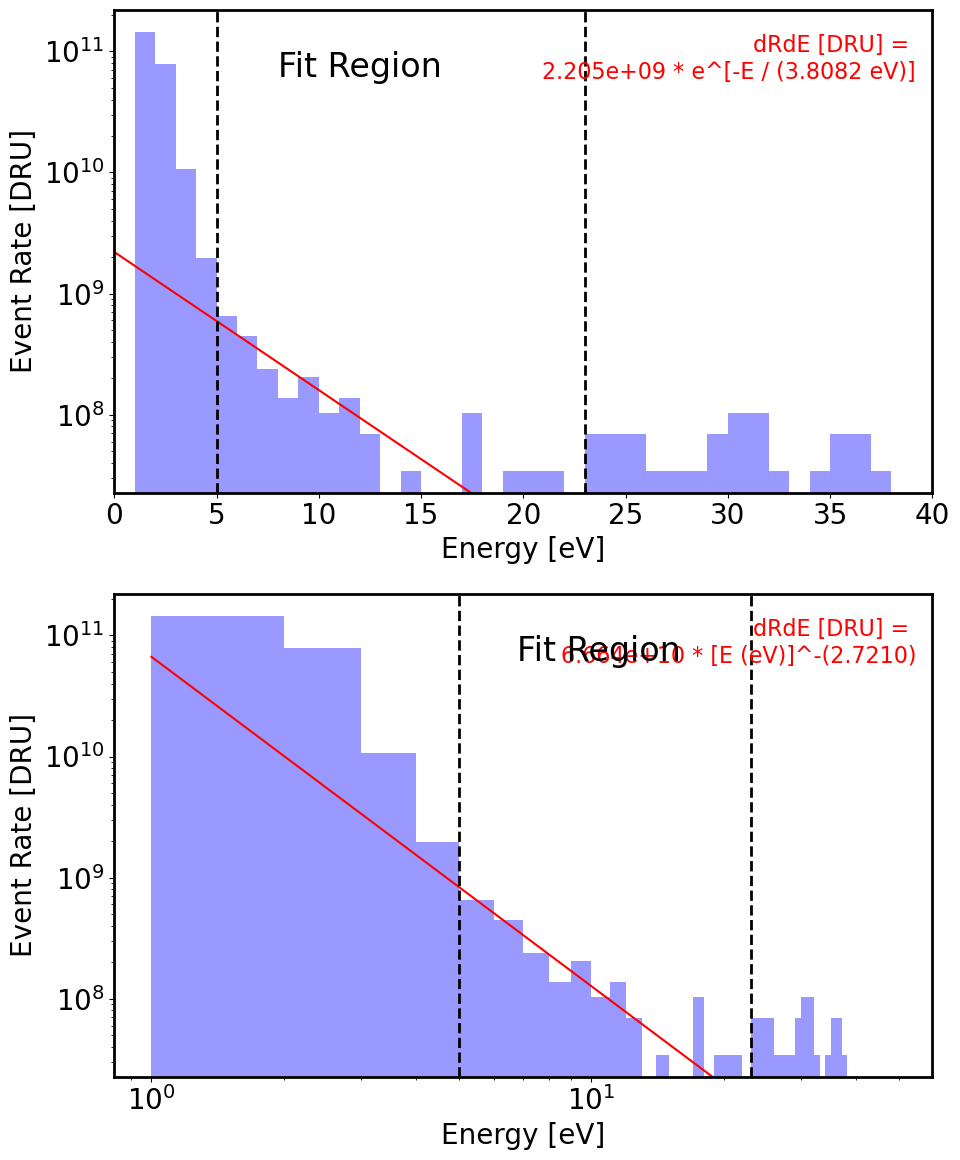

In [6]:
bins_eV_full =  np.arange(0, 50, 1)
fit_low, fit_high = 5, 23
bins_eV_fit = bins_eV_full[(bins_eV_full >= fit_low) * (bins_eV_full <= fit_high)]
fit_scale = 1e8

event_weights_DRU = np.full(len(energies_eV), (1/mass_kg/time_days/np.diff(bins_eV_fit*1e-3)[0]))
dRdE_DRU_arr, E_eV_arr = np.histogram(energies_eV, bins_eV_fit, weights=event_weights_DRU)
E_eV_arr = 0.5 * (E_eV_arr[1:] + E_eV_arr[:-1])

# Perform the optimization to minimize the negative log likelihood
result = minimize(negative_log_likelihood_power_basic, [1, 1], args=(E_eV_arr, dRdE_DRU_arr/fit_scale), method='L-BFGS-B', bounds=[(1e-10, None), (1e-10, None)])
A_fit_power_he, alpha_fit_power_he = result.x
A_fit_power_he *= fit_scale
print(f"Power law parameters: A = {A_fit_power_he:.3e} DRU, exponent = -{alpha_fit_power_he:.4f}")

# Perform the optimization to minimize the negative log likelihood
result = minimize(negative_log_likelihood_exp_basic, [1, 1], args=(E_eV_arr, dRdE_DRU_arr/fit_scale), method='L-BFGS-B', bounds=[(1e-10, None), (1e-10, None)])
A_fit_exp_he, inv_E0_exp_he = result.x
A_fit_exp_he *= fit_scale
print(f"Exponential parameters: A = {A_fit_power_he:.3e} DRU, E0 = {1 / inv_E0_exp_he:.4f} eV")

####### Plotting #######

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

for i in range(2):
    ax[i].hist(energies_eV, bins_eV_full, weights=event_weights_DRU, alpha=0.4, color='b')
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()

    if i == 0:
        ax[i].plot(bins_eV_full, exponential_basic(bins_eV_full, A_fit_exp_he, inv_E0_exp_he), 'r-')
        ax[i].text(0.98, 0.95, f'dRdE [DRU] = \n{A_fit_exp_he:.3e} * e^[-E / ({1/inv_E0_exp_he:.4f} eV)]', ha='right', va='top', fontsize=16, color='r', transform=ax[i].transAxes)
    else:
        ax[i].set_xscale('log')
        ax[i].plot(bins_eV_full, power_law_basic(bins_eV_full, A_fit_power_he, alpha_fit_power_he), 'r-')
        ax[i].text(0.98, 0.95, f'dRdE [DRU] = \n{A_fit_power_he:.3e} * [E (eV)]^-({alpha_fit_power_he:.4f})', ha='right', va='top', fontsize=16, color='r', transform=ax[i].transAxes)

    ax[i].text(16, 1e11, f'Fit Region', ha='right', va='top', fontsize=24, color='k')

    ax[i].set_xlabel('Energy [eV]')
    ax[i].set_ylabel('Event Rate [DRU]')

    ax[i].plot([fit_low, fit_low], [ymin, ymax], 'k--', lw=2)
    ax[i].plot([fit_high, fit_high], [ymin, ymax], 'k--', lw=2)
    ax[i].set_ylim([ymin, ymax])

ax[0].set_xlim([0, 40])
fig.tight_layout()
fig.show()

/tmp/ipykernel_1409351/2939457329.py:14: RuntimeWarning: divide by zero encountered in log10
  ax.plot(E_eV_arr, np.log10(dRdE_DRU_arr), 'ko', ms=8, label='Run 47 Data')
/tmp/ipykernel_1409351/1935810265.py:3: RuntimeWarning: divide by zero encountered in power
  return A * x**(-alpha)


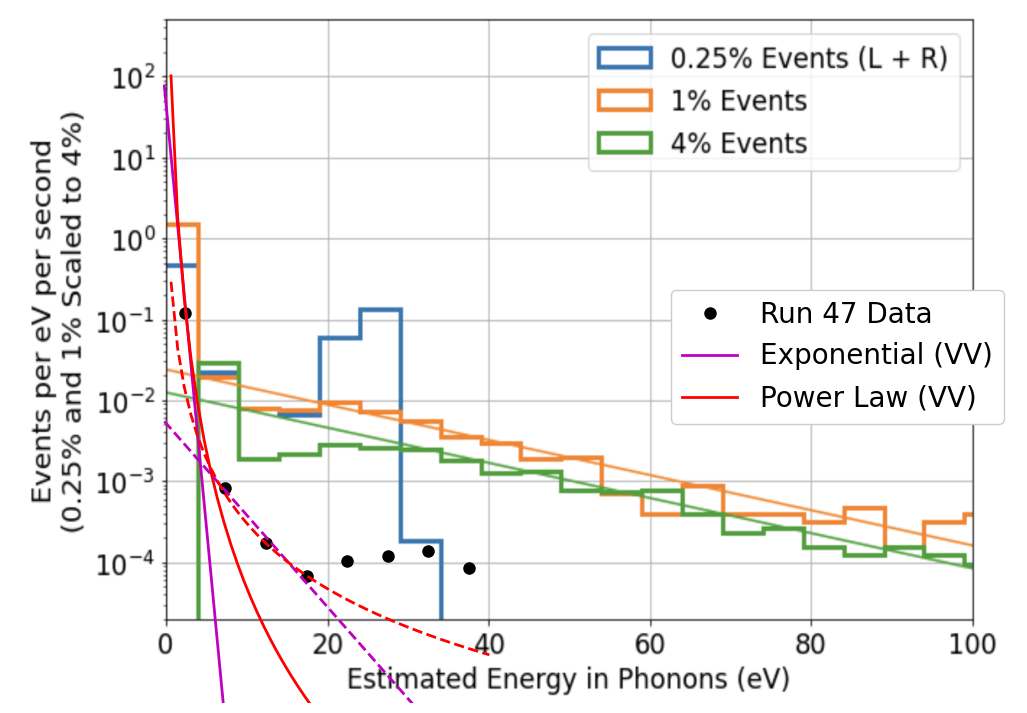

In [7]:
# Load the image
img = mpimg.imread('spectra/RKR_Run34_spectrum.png')

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(13,9))

# Display the image
ax.imshow(img, extent=[-19, 105, np.log10(2e-6), np.log10(7e2)], aspect='auto')

bins_eV = np.arange(0, 100, 5)
event_weights_eVs = np.full(len(energies_eV), (1/time_sec/np.diff(bins_eV)[0]))
dRdE_DRU_arr, E_eV_arr = np.histogram(energies_eV, bins_eV, weights=event_weights_eVs)
E_eV_arr = 0.5 * (E_eV_arr[1:] + E_eV_arr[:-1])
ax.plot(E_eV_arr, np.log10(dRdE_DRU_arr), 'ko', ms=8, label='Run 47 Data')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
E_eV_arr = np.linspace(0, 40)
ax.plot(E_eV_arr, np.log10(exponential_basic(E_eV_arr, A_fit_exp / 1000 / 86400 * mass_kg, inv_E0_exp)), 'm-', lw=2, label='Exponential (VV)')
ax.plot(E_eV_arr, np.log10(power_law_basic(E_eV_arr, A_fit_power / 1000 / 86400 * mass_kg, alpha_fit_power)), 'r-', lw=2, label='Power Law (VV)')
ax.plot(E_eV_arr, np.log10(exponential_basic(E_eV_arr, A_fit_exp_he / 1000 / 86400 * mass_kg, inv_E0_exp_he)), 'm--', lw=2)
ax.plot(E_eV_arr, np.log10(power_law_basic(E_eV_arr, A_fit_power_he / 1000 / 86400 * mass_kg, alpha_fit_power_he)), 'r--', lw=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend(loc='center right', framealpha=1)

# Show the plot
ax.axis(False)
plt.show()


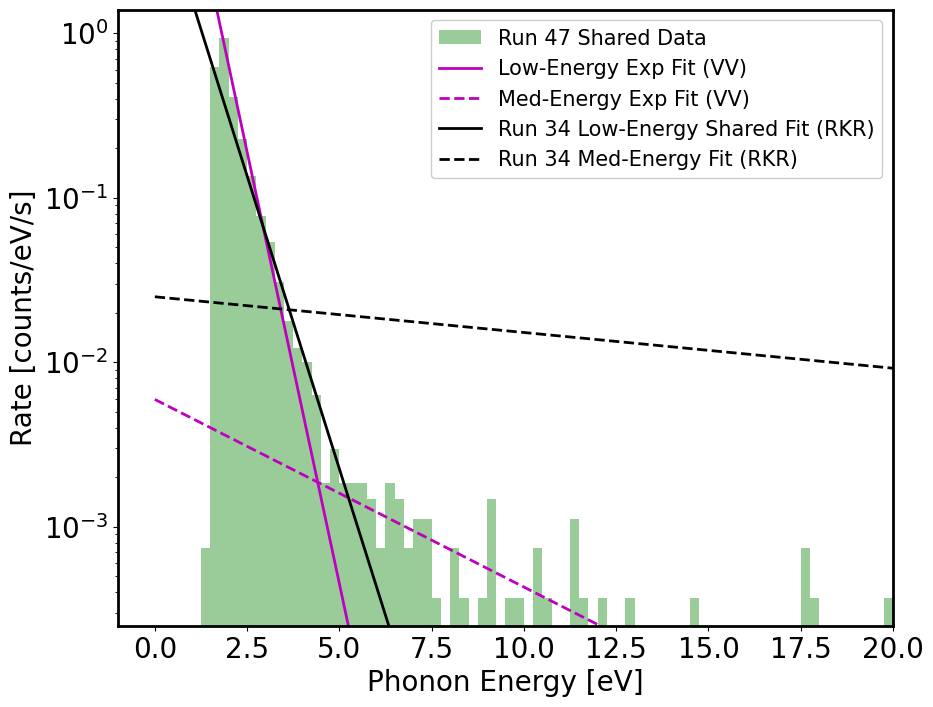

In [8]:
def get_shared_rate_phonon_eVs(energies_phonon, pce=0.164):
    energies_TES = energies_phonon * pce
    return 50 * np.exp(-energies_TES / 100e-3) * pce

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10,8))

bins_eV = np.arange(0, 50, 0.25)
event_weights_eVs = np.full(len(energies_eV), (1/time_sec/np.diff(bins_eV)[0]))
dRdE_DRU_arr, E_eV_arr = np.histogram(energies_eV, bins_eV, weights=event_weights_eVs)
E_eV_arr = 0.5 * (E_eV_arr[1:] + E_eV_arr[:-1])
#ax.plot(E_eV_arr, dRdE_DRU_arr, 'ko', ms=8, label='Run 47 Data')
ax.hist(energies_eV, bins_eV, weights=event_weights_eVs, label='Run 47 Shared Data', alpha=0.4, color='g')
ax.set_yscale('log')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
E_eV_arr = np.linspace(0, 40)
ax.plot(E_eV_arr, exponential_basic(E_eV_arr, A_fit_exp / 1000 / 86400 * mass_kg, inv_E0_exp), 'm-', lw=2, label='Low-Energy Exp Fit (VV)')
#ax.plot(E_eV_arr, np.log10(power_law_basic(E_eV_arr, A_fit_power / 1000 / 86400 * mass_kg, alpha_fit_power)), 'r-', lw=2, label='Power Law (VV)')
ax.plot(E_eV_arr, exponential_basic(E_eV_arr, A_fit_exp_he / 1000 / 86400 * mass_kg, inv_E0_exp_he), 'm--', lw=2, label='Med-Energy Exp Fit (VV)')
#ax.plot(E_eV_arr, np.log10(power_law_basic(E_eV_arr, A_fit_power_he / 1000 / 86400 * mass_kg, alpha_fit_power_he)), 'r--', lw=2)
ax.plot(E_eV_arr, get_shared_rate_phonon_eVs(E_eV_arr), 'k-', lw=2, label='Run 34 Low-Energy Shared Fit (RKR)')
ax.plot(E_eV_arr, exponential_basic(E_eV_arr, 0.025, 1/20), 'k--', lw=2, label='Run 34 Med-Energy Fit (RKR)')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Phonon Energy [eV]')
ax.set_ylabel('Rate [counts/eV/s]')
ax.legend(loc='upper right', framealpha=1, fontsize=15)
ax.set_xlim([-1, 20])
fig.show()